# Import Libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import pandas as pd
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.xception import Xception, preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import load_img, img_to_array
from tqdm import tqdm
import re
import pickle

# Question Encoding

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence is when you get the most of the language getting simple proof by contradiction where", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/facebook-dpr-question_encoder-single-nq-base')
embeddings = model.encode(questions)
print(embeddings)


In [ ]:
# Read dictionary pkl file
with open('/kaggle/input/question-embeddings/question_embeddings.pkl', 'rb') as fp:
    embeddings = pickle.load(fp)
    print('successful')

successful


In [ ]:
embeddings.shape

(658111, 768)

# Image Feature Extraction

In [ ]:
from PIL import Image
import timm
import torch
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = timm.create_model(
    'vit_base_patch14_reg4_dinov2.lvd142m',
    pretrained=True,
    num_classes=0  # remove classifier nn.Linear
).eval().to(device)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
image_dir =  '/kaggle/input/visual-question-answering/train2014/train2014'

train_features = []
for filename in tqdm(os.listdir(image_dir)):
    image_path = os.path.join(image_dir, filename)
    img = Image.open(image_path).convert("RGB")  # Convert image to RGB if needed

    # Apply transforms and move data to GPU
    inputs = transforms(img).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        output = model.forward_features(inputs)
        output = model.forward_head(output, pre_logits=True)
    train_features.append(output.cpu().numpy())# Move data back to CPU and convert to numpy array

In [ ]:
type(train_features)

In [ ]:
# add ids to features
img_ids = np.array([int(re.search("[0-9][0-9][0-9][0-9][0-9]+", gen).group()) for gen in generator.filenames])
image_features = {}
for i in range(len(img_ids)):
    image_features[img_ids[i]]= train_features[i]

In [ ]:
# Concatenate and reshape the extracted features into a numpy array
train_features = np.concatenate(train_features)
train_features = train_features.reshape((len(os.listdir(image_dir)), -1))

# Save the extracted features to a numpy file
np.save(output_file, train_features)

In [ ]:
# Save dictionary to train_image_features.pkl file
with open('val_image_features.pkl', 'wb') as fp:
    pickle.dump(train_features, fp)
    print('Dictionary saved successfully to file.')

In [ ]:
output.shape

# Read all files

In [ ]:
train_file_questions = '/kaggle/input/visual-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
train_file_annotations = '/kaggle/input/visual-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
val_file_questions = '/kaggle/input/visual-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'
val_file_annotations = '/kaggle/input/visual-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'

with open(train_file_questions, 'r') as f:
    train_questions = json.load(f)['questions']
    f.close()

with open(train_file_annotations, 'r') as f:
    train_annotations = json.load(f)['annotations']
    f.close()

with open(val_file_questions, 'r') as f:
    val_questions = json.load(f)['questions']
    f.close()

with open(val_file_annotations, 'r') as f:
    val_annotations = json.load(f)['annotations']
    f.close()


#### read all train and validate image features with IDs from the pkl files

# Read dictionary pkl file
with open('/kaggle/input/image-features/train_image_features.pkl', 'rb') as fp:
    train_imgs_features = pickle.load(fp)
    print('successful')
#Read dictionary pkl file
with open('/kaggle/input/image-features/val_image_features (1).pkl', 'rb') as fp:
    val_imgs_features = pickle.load(fp)
    print('successful')

#### append validate to train features
print("Length of train_imgs_features:", len(train_imgs_features))
print("Length of val_imgs_features:", len(val_imgs_features))

#train_imgs_features = np.concatenate((train_imgs_features, val_imgs_features), axis=0)
train_imgs_features.update(val_imgs_features)

print(len(train_imgs_features))

#### append validate questions and answers to train questions and answers

# Combine the training and validation questions and annotations
train_questions += val_questions
train_annotations += val_annotations

successful
successful
Length of train_imgs_features: 82783
Length of val_imgs_features: 40504
123287


# Extracting questions,answers,ids

In [ ]:
# Extract the questions and answers
questions = []
answers = []
features_id = []

for i in range(len(train_questions)):
    questions.append(train_questions[i]['question'])
    answers.append(train_annotations[i]['multiple_choice_answer'])
    features_id.append(train_questions[i]["image_id"])
print("Length of features_id:", len(features_id))
print("Maximum index in features_id:", max(features_id))

Length of features_id: 658111
Maximum index in features_id: 581929


# Answers to one-hot-encoding

In [ ]:
# Convert the answers to one-hot vectors
answers_tokenizer = Tokenizer()
answers_tokenizer.fit_on_texts(answers)
answer_word_index = answers_tokenizer.word_index
num_classes = len(answer_word_index)
answer_sequences = answers_tokenizer.texts_to_sequences(answers)

# Pad the answer sequences to ensure they all have the same length
max_answer_length = max(len(seq) for seq in answer_sequences)
padded_answers = pad_sequences(answer_sequences, maxlen=max_answer_length)

# Get the unique answers in the dataset and create a dictionary to map them to integer labels
unique_answers = list(set(answers))
label_map = {answer: i for i, answer in enumerate(unique_answers)}
with open('label_map_Full.pkl', 'wb') as fp:
    pickle.dump(label_map, fp)
    print('label_map save successfully to file')

# Convert the answers to integer labels and then to one-hot vectors
labels = [label_map[answer] for answer in answers]
one_hot_answers = to_categorical(labels, num_classes=len(unique_answers))

#### shape of the dataset

print(len(features_id))
print(embeddings.shape)
print(one_hot_answers.shape)

label_map save successfully to file
658111
(658111, 768)
(658111, 29332)


# Train,Test,Validation split

In [ ]:
### split train into 80% train and 20% test
#### (inplace to prevent memory overflow)

split_indices = np.random.randint(low=0, high=len(features_id), size=int(len(features_id)*0.2))
split_indices = sorted(split_indices,reverse=True)

test_padded_sequences = []
padded_sequences = list(embeddings)
for i in split_indices:
    test_padded_sequences.append(padded_sequences.pop(i))

test_one_hot_answers = []
one_hot_answers = list(one_hot_answers)
for i in split_indices:
    test_one_hot_answers.append(one_hot_answers.pop(i))

test_features_id = []
for i in split_indices:
    test_features_id.append(features_id.pop(i))

### split 30% test into 20% test and 10% validate
#### (inplace to prevent memory overflow)

split_indices = np.random.randint(low=0, high=len(test_features_id), size=int(len(test_features_id)*0.5))
split_indices = sorted(split_indices,reverse=True)

val_padded_sequences = []
for i in split_indices:
    val_padded_sequences.append(test_padded_sequences.pop(i))

val_one_hot_answers = []
for i in split_indices:
    val_one_hot_answers.append(test_one_hot_answers.pop(i))

val_features_id = []
for i in split_indices:
    val_features_id.append(test_features_id.pop(i))
print("Length of val_features_id:", len(val_features_id))
print("Maximum index in val_features_id:", max(val_features_id))


Length of val_features_id: 65811
Maximum index in val_features_id: 581929


In [ ]:
# Load the saved model
model = tf.keras.models.load_model("/kaggle/input/dino_dpr/tensorflow2/version-2/1/Dino_DPR_2.h5")
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

In [ ]:
model.summary()

# Architecture


In [ ]:
# Define the input layers
question_input = Input(shape=(768, ), name='question_input')
image_input = Input(shape=(768, ), name='image_input')

# Define the dense layer for the image features
image_dense = Dense(units=256, activation='relu', name='image_dense')(image_input)
image_dense = Dropout(0.2, name='image_dropout')(image_dense)

# Concatenate the output from the LSTM and dense layers
concatenated = concatenate([question_input, image_input], name='concatenated')

dense_cnc = Dense(units=512, activation='relu', name='dens_conc')(concatenated)
dense_cnc2 = Dense(units=256, activation='relu', name='dens_conc2')(dense_cnc)
dense_cnc3 = Dense(units=512, activation='relu', name='dens_conc3')(dense_cnc2)
dense_cnc4 = Dense(units=256, activation='relu', name='dens_conc4')(dense_cnc3)
# Define the output layer for the classification
output = Dense(units=len(unique_answers), activation='softmax', name='output')(dense_cnc4)

In [ ]:
model = Model(inputs=[question_input, image_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
model.summary()

# Data Generator for training

In [ ]:
def data_generator(image_features, padded_questions, labels, batch_size):
        num_samples = len(labels)
        steps_per_epoch = num_samples // batch_size
        while True:
            for i in range(steps_per_epoch):
                batch_image_features = []
                for j in range(i*batch_size, (i+1)*batch_size):
                     # Check if the index is within bounds
                    if j < len(image_features):
                        batch_image_features.append(train_imgs_features[image_features[j]])
                batch_padded_questions = padded_questions[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]
                yield (
                  (
                    tf.convert_to_tensor(batch_padded_questions, dtype=tf.float32),
                    tf.convert_to_tensor(batch_image_features, dtype=tf.float32)
                  ),
                tf.convert_to_tensor(batch_labels, dtype=tf.float32)
               )

Using only (1/4)th of dataset as specified in project

In [ ]:
size = len(features_id)
split = size//4
fd = features_id[:split]
ps = padded_sequences[:split]
oha = one_hot_answers[:split]
size = len(val_features_id)
val_split = (size//4)
vfd = val_features_id[:val_split]
vps = val_padded_sequences[:val_split]
voha = val_one_hot_answers[:val_split]
len(voha)

16452

In [ ]:
# Define a function to generate data for evaluation
def eval_data_generator(image_features, padded_questions, batch_size):
    num_samples = len(image_features)
    steps_per_epoch = num_samples // batch_size
    while True:
        for i in range(steps_per_epoch):
            batch_image_features = []
            for j in range(i * batch_size, (i + 1) * batch_size):
                # Check if the index is within bounds
                if j < len(image_features):
                    batch_image_features.append(train_imgs_features[image_features[j]])
            batch_padded_questions = padded_questions[i * batch_size:(i + 1) * batch_size]
            yield (
                (
                    tf.convert_to_tensor(batch_padded_questions, dtype=tf.float32),
                    tf.convert_to_tensor(batch_image_features, dtype=tf.float32)
                )
            )

# Training Loop
(This epochs are 16-20)

In [ ]:
batch_size = 64
steps_per_epoch = len(oha) // batch_size

# Khởi tạo ModelCheckpoint
# checkpoint = ModelCheckpoint('xception_lstm_all_Full_80.h5', monitor='val_accuracy', save_best_only=True)
checkpoint = ModelCheckpoint('dino_lstm.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(data_generator(fd, ps ,oha,batch_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=5,
                        validation_data = data_generator(vfd,vps,voha,batch_size),
                        validation_steps = int(len(vfd)/batch_size),
                        callbacks=[checkpoint])

Epoch 1/5
   1/2056 ━━━━━━━━━━━━━━━━━━━━ 1:56:17 3s/step - accuracy: 0.0000e+00 - loss: 17.7501

I0000 00:00:1715879407.714430      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715879407.730356      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2056/2056 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2552 - loss: 4.9577

W0000 00:00:1715879947.775854      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2056/2056 ━━━━━━━━━━━━━━━━━━━━ 611s 296ms/step - accuracy: 0.2553 - loss: 4.9573 - val_accuracy: 0.3222 - val_loss: 3.5649
Epoch 2/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 601s 292ms/step - accuracy: 0.3107 - loss: 3.5197 - val_accuracy: 0.3332 - val_loss: 3.3745
Epoch 3/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 598s 291ms/step - accuracy: 0.3285 - loss: 3.2965 - val_accuracy: 0.3315 - val_loss: 3.2985
Epoch 4/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 599s 291ms/step - accuracy: 0.3399 - loss: 3.1587 - val_accuracy: 0.3253 - val_loss: 3.2768
Epoch 5/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 592s 288ms/step - accuracy: 0.3501 - loss: 3.0540 - val_accuracy: 0.3227 - val_loss: 3.2658


# Model Save

In [ ]:
# Save the trained model
model.save("Dino_DPR_2.h5")

# Graph Plots

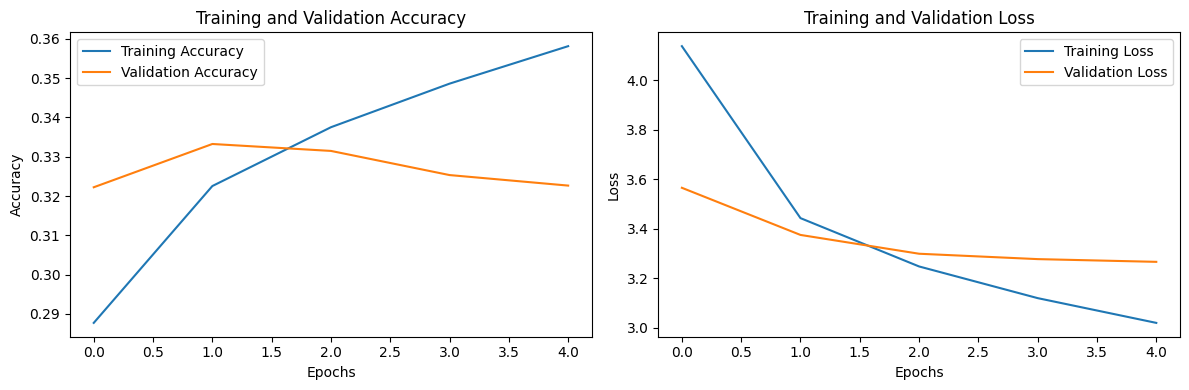

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vit_lstm.jpg')

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

# Testing

In [ ]:
a = data_generator(test_features_id,test_padded_sequences,test_one_hot_answers,1)

# Prediction on Test Data

In [ ]:
i=65811
p=[]
t=[]
while(i):
    inp,labels = next(a)
    pred = model.predict(inp)
    true_class = np.argmax(labels,axis=1)
    pred_class = np.argmax(pred,axis=1)
    p.append(pred_class)
    t.append(true_class)
    i=i-1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(t, p)
print(report)

              precision    recall  f1-score   support

           7       0.00      0.00      0.00         0
          21       1.00      1.00      1.00         1
          23       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          37       1.00      0.75      0.86         4
          40       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         0
          54       0.00      0.00      0.00         0
          69       1.00      1.00      1.00         1
          70       1.00      1.00      1.00         1
          74       0.00      0.00      0.00         0
          78       0.00      0.00      0.00         0
          79       0.00      0.00      0.00         0
          86       0.00      0.00      0.00         1
          88       0.67      0.40      0.50         5
          94       0.00      0.00      0.00         0
          98       0.00      0.00      0.00         0
         100       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [ ]:
import pandas as pd

# Define the data
data = {
    "metrics": ["macro avg", "weighted avg"],
    "precision": [0.08, 0.78],
    "recall": [0.06, 0.23],
    "f1-score": [0.06, 0.33],
    "support": [6581, 6581]
}
print("Test Accuracy is : 23%")
# Create a DataFrame
df = pd.DataFrame(data)
df

Test Accuracy is : 23%


,metrics,precision,recall,f1-score,support
0,macro avg,0.08,0.06,0.06,6581
1,weighted avg,0.78,0.23,0.33,6581


In [ ]:
print("Train Accuracy : 35.01% for 20 epochs")
print("Validation Accuracy : 32.27% for 20 epochs")

Train Accuracy : 35.01% for 20 epochs
Validation Accuracy : 32.27% for 20 epochs
